In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import pandas as pd

In [2]:
vent = pd.read_csv("vent.csv", sep=";")
vent["time"] = pd.to_datetime(vent["time"], format="%Y-%m-%d %H:%M:%S")  # Make time to type time

vent = vent[vent["Id"] !=10] # Dropping line going up (look at documentation)
vent = vent[vent["local time"] <70]

# Needed to have one column regardless of which room the venting was in
def temperature_deduction(row):
    if row["room"] == "up":
        return row["temperature_bathoroom_upstairs"]
    elif row["room"] == "mid" or row["room"] == "middle":
        return row["temperature_bathroom_middle"]
    else:
        raise Exception("unkonwn floor: " + row["room"])
vent["temperature"] = vent.apply(lambda row: temperature_deduction(row), axis=1)

def humidity_deduction(row):
    if row["room"] == "up":
        return row["humidity_bathroom_upstairs"]
    elif row["room"] == "mid" or row["room"] == "middle":
        return row["humidity_bathroom_middle"]
    else:
        raise Exception("unkonwn floor: " + row["room"])
vent["humidity_goal"] = vent.apply(lambda row: humidity_deduction(row), axis=1)



def config_code_to_size(row): # Converting the window code to the actual sizes
    code_mid = {1: 0.8*0.95, 2: 2*0.8*0.95, 3: 0.95*0.15 + 0.80*0.005, 4: 2*(0.95*0.15 + 0.80*0.005)}
    code_up = 0.6*0.9
    
    if row["room"] == "mid":
        return code_mid[row["Config"]]
    else:
        return code_up

vent["Config"] = vent.apply(lambda row: config_code_to_size(row), axis=1)

def room_code_to_size(row): # Converting the window code to the actual sizes
    if row["room"] == "mid":
        return 15*3
    else:
        return 10*3

vent["room"] = vent.apply(lambda row: room_code_to_size(row), axis=1)

def first_value(row):
    first_values_local =  vent[(row["Id"] == vent["Id"]) & (vent["local time"] == 0)]
    try:
        return first_values_local["humidity_goal"].values[0], first_values_local["temperature"].values[0], first_values_local["humidity_outside"].values[0], first_values_local["temperature_outside"].values[0]
    except:
        return pd.NA, pd.NA, pd.NA, pd.NA

# Variables we only know from the first point in "production" so this is being simulated
first_values = vent.apply(
            lambda row: pd.Series(first_value(row), index=["humidity", "temperature", "humidity_outside",
                                                           "temperature_outside"]), axis=1)

relevant_vent = vent[["room", "Config", "local time", "humidity_goal"]]  # In the end this will be a minimum subset of data needed
# (column wise) so we do not drop too many lines removing NaNs

relevant_vent = pd.concat([first_values, relevant_vent], axis=1)
relevant_vent = relevant_vent.dropna(axis=0, how="any")
relevant_vent = relevant_vent.apply(pd.to_numeric)


In [3]:
relevant_vent = relevant_vent[relevant_vent["humidity"] > relevant_vent["humidity_goal"]]

In [4]:
def e_s(T): # Source https://journals.ametsoc.org/view/journals/bams/86/2/bams-86-2-225.xml?tab_body=pdf Equation 6 p.226
    C_1 = 610.94 #Kp
    A_1 =  17.625
    B_1 =243.04 #°C
    return C_1*np.exp((A_1*T)/(B_1+T))

def h(h_0, h_out, F_größe, R_größe, t, k_1, k_2):  # The absolute humidity model
    return (h_0 -h_out)/((t+1)**((k_1*F_größe)/(k_2*R_größe))) + h_out

def T(T_0, T_out, F_größe, R_größe, t, k_1, k_2): # The temperature model
    return (T_0-T_out)/((t+1)**((k_1*F_größe)/(k_2*R_größe))) + T_out

def model_h(window, room, L_out, L_begin, T_out, T_begin,t, k1,k2,k3,k4, training=False):
    L_abs_begin = (L_begin/100)*e_s(T_begin)
    L_abs_out = (L_out/100)*e_s(T_out)
    pred_T = T(T_begin, T_out, window, room, t, k3, k4)
    pred_L = h(L_abs_begin, L_abs_out, window, room, t, k1, k2)
    result= (pred_L/e_s(pred_T))*100
    
    if training:
        to_return = []
        for res in result:
            if res >100:
                to_return.append(-np.inf)
            else:
                to_return.append(res)
        return to_return
    return result

In [5]:
def get_F(L_in, configs, func):
    def F(parameters):
        if [i for i in parameters if i <0]:
            return np.inf
        return sum((func(*configs, *parameters, training=True) - L_in)**2) # The sum of all errors through all measurements
    return F



# Functions generating the square error for given constants
error_sum = get_F(relevant_vent["humidity_goal"], (relevant_vent["Config"], relevant_vent["room"], relevant_vent["humidity_outside"], 
                                                   relevant_vent["humidity"], relevant_vent["temperature_outside"], relevant_vent["temperature"], relevant_vent["local time"]), model_h)


In [6]:
start_values =   [50,1,50,1]

res = sco.least_squares(error_sum, start_values, max_nfev=10**6)#
res

 active_mask: array([0., 0., 0., 0.])
        cost: 486208.09642195975
         fun: array([986.11165334])
        grad: array([  -7.03102842,  154.02717754,   29.56648679, -173.74319241])
         jac: array([[-0.00713005,  0.15619649,  0.0299829 , -0.17619018]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 223
        njev: 217
  optimality: 173.74319240528644
      status: 2
     success: True
           x: array([49.9737675 ,  2.28452262, 49.3679433 ,  8.39747826])

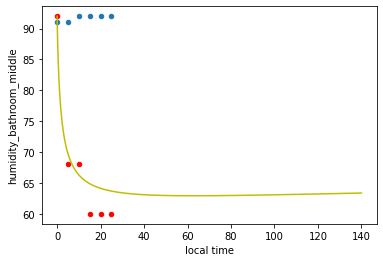

In [8]:
ax = vent[vent["Id"] == 6].plot.scatter(x="local time", y="humidity_outside")
vent[vent["Id"] == 6].plot.scatter(x="local time", y="humidity_bathroom_middle", ax=ax, color="red")


x = np.linspace(0,140,500)
y =  model_h(0.51, 20, 91,92, 3, 16.9,x, *res["x"])

plt.plot(x,y, 'y')
plt.show()
